In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Given constants

#mass of helicopter [kg]
m = 544

#gravity constant [m/s2]
g = 9.81

#density of air at Sea Level [kg/m3] or 0[m] altitude
rho_0 = 1.2256

#density of air [kg/m3] at 2000 [ft] or 609.6 [m] in real units
rho_609 = 1.15490

#efficiency from battery to rotor
efficiency = 0.95

In [3]:
#CT/sigma values
CT_v_sigmas = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]

#corresponding FM values
FMs = [0,0.2, 0.4,0.5,0.55,0.57,0.58,0.59,0.6,0.6,0.6,0.6,0.6]

Text(0.5,1,'FM as a function of CT/sigma')

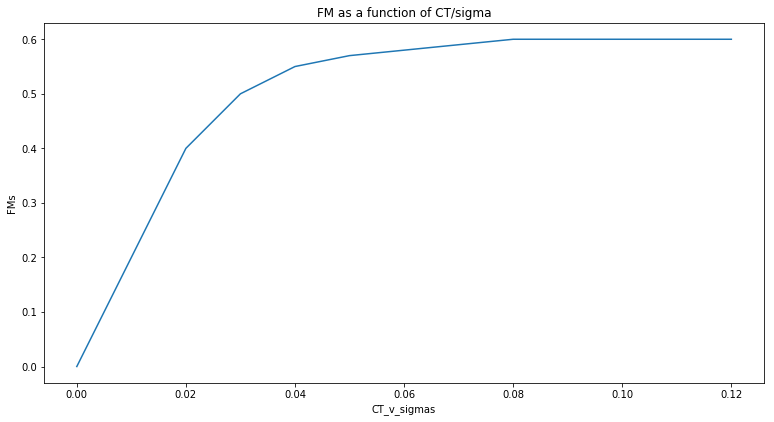

In [4]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.plot(CT_v_sigmas,FMs)
ax.set_xlabel('CT_v_sigmas')
ax.set_ylabel('FMs')
ax.set_title('FM as a function of CT/sigma')


In [5]:
def thrust_per_rotor(m,g,number_rotors):
    T_per_rotor = m*g/number_rotors
    return T_per_rotor 

In [6]:
#this function returns CT and CP of a single rotor (or induced power) given Thrust (mg at hover) [kg*m/s2], density of fluid [kg/m3], 
#omega of blade [rad/s], radius [m]

def CT_and_CP(m,g,rho,omega,r,number_rotors):
    
    T = thrust_per_rotor(m,g,number_rotors)
    
    CT = T/(rho*(np.pi*r**2)*(omega*r)**2)
    
    #CP is the same as induced power
    CP = (CT**(1.5))/((2)**0.5)
    return CT,CP

In [7]:
#this function returns disk loading given Thrust (mg at hover) [kg*m/s2] and area of rotor disk [m2]
#disk loading represents the average pressure change across an actuator disk

def disk_loading(m,g,r,number_rotors):
    
    T = thrust_per_rotor(m,g,number_rotors)
    
    disk_loading = T/(np.pi*r**2)
    
    return disk_loading

In [8]:
#this function returns the power loading

def power_loading(m,g,rho,omega,r,number_rotors):
    # CP = P/rho*A*(omega*R)^3
    # Therefore P = CP*rho*A*(omega*R)^3
    T = thrust_per_rotor(m,g,number_rotors)
    
    #CP is the second output of the CT_and_CP function
    P = (CT_and_CP(m,g,rho,omega,r,number_rotors)[1])*rho*np.pi*r**2*((omega*r)**3)
    power_loading = T/P
    return power_loading

In [9]:
#FM is the ideal induced power (CP) divided by the actual power ((sigma*cd0/8) + kappa*CP)

def FM_linear_interp(number_blades,chord,m,g,rho,omega,r,number_rotors):
    #CT/sigma values
    CT_v_sigmas = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]

    #corresponding FM values
    FMs = [0,0.2, 0.4,0.5,0.55,0.57,0.58,0.59,0.6,0.6,0.6,0.6,0.6]
    
    CT = CT_and_CP(m,g,rho,omega,r,number_rotors)[0]
    
    #sigma is the total blade area divided by the rotor disk area
    sigma = number_blades*chord/(np.pi*r)
    
    CT_div_sigma = CT/sigma
    
    FM_approx = np.interp(CT_div_sigma,CT_v_sigmas,FMs)
    
    return FM_approx

In [10]:
#the total power is the sum of the induced power, the actual power, tail rotor power parasite power (assumed 0 during hover because the\
#rotorcraft has no forward velocity, and ancillary power (used to power AC, generators, phone chargers maybe???))

def total_power(number_blades,chord,m,g,rho,omega,r,tail_rotor_percent_increase,number_rotors):
    induced_power_unitless = (CT_and_CP(m,g,rho,omega,r, number_rotors)[1])
    
    induced_power = induced_power_unitless*rho*np.pi*(r**2)*((omega*r)**3)
    
    #the actual power is the numerator of FM, and we can solve for it easily
    actual_power_unitless = induced_power_unitless/FM_linear_interp(number_blades,chord,m,g,rho,omega,r, number_rotors)
    
    #now we account for the additional power needed by the tail_rotor
    total_power_account_tail_unitless = (actual_power_unitless)*(1+tail_rotor_percent_increase)
    
    #we need to multiply this unitless power by rho*A*(omega*r)^3
    total_power = total_power_account_tail_unitless*rho*np.pi*(r**2)*(omega*r)**3
    
    return induced_power, total_power


In [11]:
#the required power for the aircraft is the total power per rotor times the number of rotors divided by the efficiency from battery to rotor

def required_power(number_blades,chord,m,g,rho,omega,r,tail_rotor_percent_increase,number_rotors,efficiency):
    total_power_all_rotors = number_rotors*total_power(number_blades,chord,m,g,rho,omega,r,tail_rotor_percent_increase,number_rotors)[1]
    required_power = total_power_all_rotors/efficiency
    
    return required_power

In [12]:
#first configuration

r_1 = 7*0.3048 #[m]
n_blades_1 = 6
chord_1 = 0.33*0.3048 #[m]
omega_1 = 955*9.5493 #[rad/sec]
tail_rotor_percent_1 = 0.15
number_rotors_1 = 1
name_config_1 = 'Single main rotor/Tail rotor'


#second configuration

r_2 = 0.61 #[m]
n_blades_2 = 3
chord_2 = 2*0.0254 #[m]
omega_2 = 350 #[rad/sec]
tail_rotor_percent_2 = 0
number_rotors_2 = 4
name_config_2 = 'Quadcopter'

#third configuration

r_3 = 4.5*0.3048 #[m]
n_blades_3 = 5
chord_3 = 7.62*0.01 #[m]
omega_3 = 155 #[rad/sec]
tail_rotor_percent_3 = 0
number_rotors_3 = 2
name_config_3 = 'Tandem rotor'

#fourth configuration

r_4 = 1.6*0.3048 #[m]
n_blades_4 = 4
chord_4 = 1.5*0.0254 #[m]
omega_4 = 3342*9.5493 #[rad/sec]
tail_rotor_percent_4 = 0
number_rotors_4 = 6
name_config_4 = 'Hexacopter'


In [13]:
#returns a script for each configuration

def everything(name_config,n_blades,chord,m,g,rho_sea,rho_high,omega,r,tail_rotor_percent,number_rotors,efficiency):
   #sea level values
    single_rotor_disk_0 = disk_loading(m,g,r,number_rotors)
    single_rotor_power_loading_0 = power_loading(m,g,rho_0,omega,r,number_rotors)
    ideal_power_per_rotor_0 = total_power(n_blades,chord,m,g,rho_0,omega,r,tail_rotor_percent,number_rotors)[0]
    total_power_per_rotor_0 = total_power(n_blades,chord,m,g,rho_0,omega,r,tail_rotor_percent,number_rotors)[1]
    required_power_total_0= required_power(n_blades,chord,m,g,rho_0,omega,r,tail_rotor_percent,number_rotors,efficiency)
    
    results_ssl = [single_rotor_disk_0,single_rotor_power_loading_0,ideal_power_per_rotor_0,total_power_per_rotor_0,required_power_total_0]
   
    #accounting for change in g at 2000ft, g = 9.98 m/s2
    single_rotor_disk_609 = disk_loading(m,g,r,number_rotors)
    single_rotor_power_loading_609 = power_loading(m,g,rho_609,omega,r,number_rotors)
    ideal_power_per_rotor_609 = total_power(n_blades,chord,m,g,rho_609,omega,r,tail_rotor_percent,number_rotors)[0]
    total_power_per_rotor_609 = total_power(n_blades,chord,m,g,rho_609,omega,r,tail_rotor_percent,number_rotors)[1]
    required_power_total_609= required_power(n_blades,chord,m,g,rho_609,omega,r,tail_rotor_percent,number_rotors,efficiency)
    
    results_609 = [single_rotor_disk_609,single_rotor_power_loading_609,ideal_power_per_rotor_609,total_power_per_rotor_609,required_power_total_609]
    
    print('For the '+name_config+' at Sea Level:\n- the Single rotor Disk loading is '+str(round(single_rotor_disk_0, 2))+' [Pa]\n- the Single rotor Power loading is '+str(round(single_rotor_power_loading_0, 2))+' [N/W]\n- the ideal power per rotor is '+str(round(ideal_power_per_rotor_0, 2))+' [W]\n- the total power per rotor is '+str(round(total_power_per_rotor_0, 2))+' [W]\n- the required power for the entire aircraft is '+str(round(required_power_total_0, 2))+' [W]\n')
    print('For the '+name_config+' at 2000 feet in altitude:\n- the Single rotor Disk loading is '+str(round(single_rotor_disk_609, 2))+' [Pa]\n- the Single rotor Power loading is '+str(round(single_rotor_power_loading_609, 2))+' [N/W]\n- the ideal power per rotor is '+str(round(ideal_power_per_rotor_609, 2))+' [W]\n- the total power per rotor is '+str(round(total_power_per_rotor_609, 2))+' [W]\n- the required power for the entire aircraft is '+str(round(required_power_total_609, 2))+' [W]')
    
    return results_ssl,results_609

In [14]:
first_config_results = everything(name_config_1,n_blades_1,chord_1,m,g,rho_0,rho_609,omega_1,r_1,tail_rotor_percent_1,number_rotors=1,efficiency=0.95)

For the Single main rotor/Tail rotor at Sea Level:
- the Single rotor Disk loading is 373.16 [Pa]
- the Single rotor Power loading is 0.08 [N/W]
- the ideal power per rotor is 65845.26 [W]
- the total power per rotor is 423879307.63 [W]
- the required power for the entire aircraft is 446188744.87 [W]

For the Single main rotor/Tail rotor at 2000 feet in altitude:
- the Single rotor Disk loading is 373.16 [Pa]
- the Single rotor Power loading is 0.08 [N/W]
- the ideal power per rotor is 67830.77 [W]
- the total power per rotor is 411471756.78 [W]
- the required power for the entire aircraft is 433128165.03 [W]


In [15]:
second_config_results = everything(name_config_2,n_blades_2,chord_2,m,g,rho_0,rho_609,omega_2,r_2,tail_rotor_percent_2,number_rotors_2,efficiency=0.95)

For the Quadcopter at Sea Level:
- the Single rotor Disk loading is 1141.3 [Pa]
- the Single rotor Power loading is 0.05 [N/W]
- the ideal power per rotor is 28788.41 [W]
- the total power per rotor is 47980.69 [W]
- the required power for the entire aircraft is 202023.95 [W]

For the Quadcopter at 2000 feet in altitude:
- the Single rotor Disk loading is 1141.3 [Pa]
- the Single rotor Power loading is 0.04 [N/W]
- the ideal power per rotor is 29656.5 [W]
- the total power per rotor is 49427.5 [W]
- the required power for the entire aircraft is 208115.8 [W]


In [16]:
third_config_results = everything(name_config_3,n_blades_3,chord_3,m,g,rho_0,rho_609,omega_3,r_3,tail_rotor_percent_3,number_rotors_3,efficiency=0.95)

For the Tandem rotor at Sea Level:
- the Single rotor Disk loading is 451.47 [Pa]
- the Single rotor Power loading is 0.07 [N/W]
- the ideal power per rotor is 36213.05 [W]
- the total power per rotor is 60355.08 [W]
- the required power for the entire aircraft is 127063.33 [W]

For the Tandem rotor at 2000 feet in altitude:
- the Single rotor Disk loading is 451.47 [Pa]
- the Single rotor Power loading is 0.07 [N/W]
- the ideal power per rotor is 37305.02 [W]
- the total power per rotor is 62175.03 [W]
- the required power for the entire aircraft is 130894.8 [W]


In [17]:
fourth_config_results = everything(name_config_4,n_blades_4,chord_4,m,g,rho_0,rho_609,omega_4,r_4,tail_rotor_percent_4,number_rotors_4,efficiency=0.95)

For the Hexacopter at Sea Level:
- the Single rotor Disk loading is 1190.41 [Pa]
- the Single rotor Power loading is 0.05 [N/W]
- the ideal power per rotor is 19600.89 [W]
- the total power per rotor is 24312162.96 [W]
- the required power for the entire aircraft is 153550502.89 [W]

For the Hexacopter at 2000 feet in altitude:
- the Single rotor Disk loading is 1190.41 [Pa]
- the Single rotor Power loading is 0.04 [N/W]
- the ideal power per rotor is 20191.93 [W]
- the total power per rotor is 23600511.33 [W]
- the required power for the entire aircraft is 149055861.05 [W]


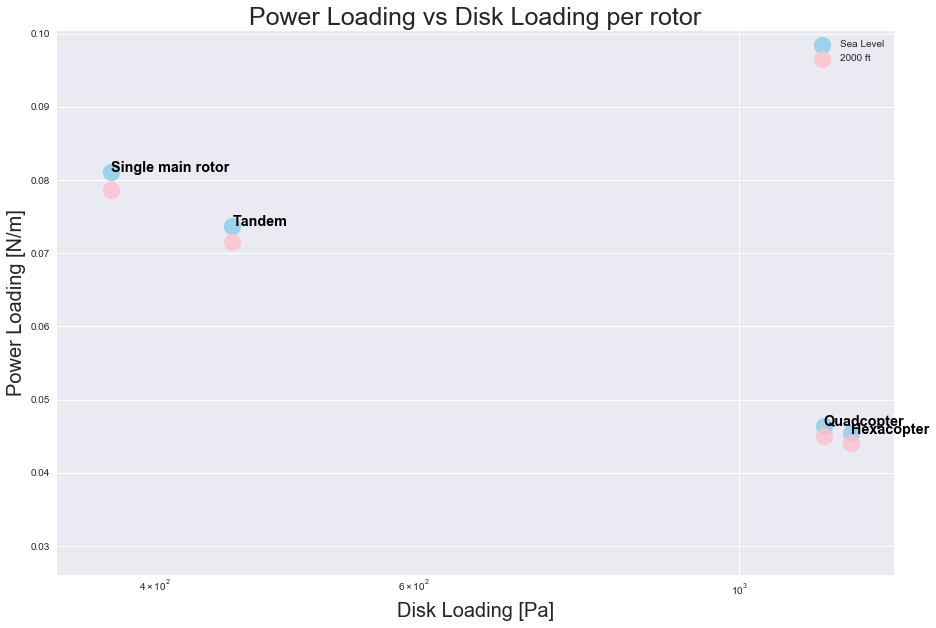

In [18]:
disk_loadings_0 = [first_config_results[0][0],second_config_results[0][0],third_config_results[0][0],fourth_config_results[0][0]]
power_loadings_0 = [first_config_results[0][1],second_config_results[0][1],third_config_results[0][1],fourth_config_results[0][1]]

disk_loadings_609 = [first_config_results[1][0],second_config_results[1][0],third_config_results[1][0],fourth_config_results[1][0]]
power_loadings_609 = [first_config_results[1][1],second_config_results[1][1],third_config_results[1][1],fourth_config_results[1][1]]


import matplotlib.pylab as plt
import seaborn as sns
 
# Create dataframe
df = pd.DataFrame({
'x': disk_loadings_0,
'y': power_loadings_0,
'group': ['Single main rotor','Quadcopter','Tandem','Hexacopter']
})

df2 = pd.DataFrame({
'x2': disk_loadings_609,
'y2': power_loadings_609,
'group2': ['Single main rotor','Quadcopter','Tandem','Hexacopter']
})

sns.set(rc={'figure.figsize':(15,10)})
p1=sns.regplot(data=df, x="x", y="y",label="Sea Level", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':300})
p1=sns.regplot(data=df2, x="x2", y="y2",label="2000 ft", fit_reg=False, marker="o", color="pink", scatter_kws={'s':300})
p1.set_xscale('log')
p1.set_xlabel('Disk Loading [Pa]', fontsize = 20)
p1.set_ylabel('Power Loading [N/m]', fontsize = 20) 
p1.set_title('Power Loading vs Disk Loading per rotor', fontsize = 25)
p1.legend()
# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', size='large', color='black', weight='semibold')


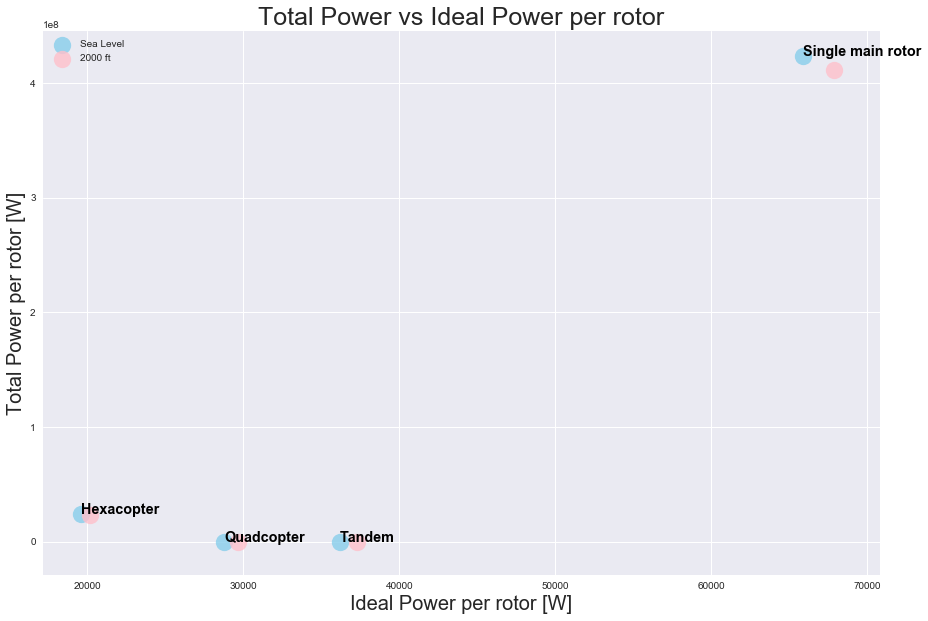

In [19]:
ideal_power_0 = [first_config_results[0][2],second_config_results[0][2],third_config_results[0][2],fourth_config_results[0][2]]
total_power_0 = [first_config_results[0][3],second_config_results[0][3],third_config_results[0][3],fourth_config_results[0][3]]
ideal_power_609 = [first_config_results[1][2],second_config_results[1][2],third_config_results[1][2],fourth_config_results[1][2]]
total_power_609 = [first_config_results[1][3],second_config_results[1][3],third_config_results[1][3],fourth_config_results[1][3]]


#plot total power vs ideal power per rotor

import matplotlib.pylab as plt
import seaborn as sns
 
# Create dataframe
df3 = pd.DataFrame({
'x3': ideal_power_0,
'y3': total_power_0,
'group3': ['Single main rotor','Quadcopter','Tandem','Hexacopter']
})

df4 = pd.DataFrame({
'x4': ideal_power_609,
'y4': total_power_609,
'group4': ['Single main rotor','Quadcopter','Tandem','Hexacopter']
})

import matplotlib.pylab as plt
import seaborn as sns



sns.set(rc={'figure.figsize':(15,10)})
p2=sns.regplot(data=df3, x="x3", y="y3",label="Sea Level", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':300})
p2=sns.regplot(data=df4, x="x4", y="y4",label="2000 ft", fit_reg=False, marker="o", color="pink", scatter_kws={'s':300})
p2.set_xlabel('Ideal Power per rotor [W]', fontsize = 20)
p2.set_ylabel('Total Power per rotor [W]', fontsize = 20) 
p2.set_title('Total Power vs Ideal Power per rotor', fontsize = 25)
p2.legend()
# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     p2.text(df3.x3[line]+0.2, df3.y3[line], df3.group3[line], horizontalalignment='left', size='large', color='black', weight='semibold')


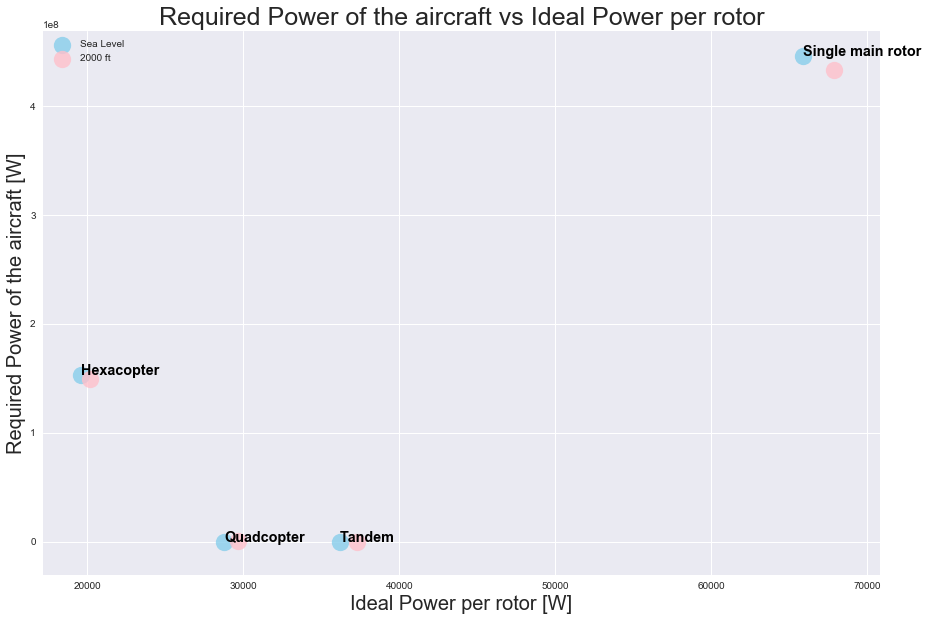

In [20]:
ideal_power_0 = [first_config_results[0][2],second_config_results[0][2],third_config_results[0][2],fourth_config_results[0][2]]
required_power_0 = [first_config_results[0][4],second_config_results[0][4],third_config_results[0][4],fourth_config_results[0][4]]
ideal_power_609 = [first_config_results[1][2],second_config_results[1][2],third_config_results[1][2],fourth_config_results[1][2]]
required_power_609 = [first_config_results[1][4],second_config_results[1][4],third_config_results[1][4],fourth_config_results[1][4]]


#plot total power vs ideal power per rotor

import matplotlib.pylab as plt
import seaborn as sns
 
# Create dataframe
df5 = pd.DataFrame({
'x5': ideal_power_0,
'y5': required_power_0,
'group5': ['Single main rotor','Quadcopter','Tandem','Hexacopter']
})

df6 = pd.DataFrame({
'x6': ideal_power_609,
'y6': required_power_609,
'group6': ['Single main rotor','Quadcopter','Tandem','Hexacopter']
})


sns.set(rc={'figure.figsize':(15,10)})
p3=sns.regplot(data=df5, x="x5", y="y5",label="Sea Level", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':300})
p3=sns.regplot(data=df6, x="x6", y="y6",label="2000 ft", fit_reg=False, marker="o", color="pink", scatter_kws={'s':300})
p3.set_xlabel('Ideal Power per rotor [W]', fontsize = 20)
p3.set_ylabel('Required Power of the aircraft [W]', fontsize = 20) 
p3.set_title('Required Power of the aircraft vs Ideal Power per rotor', fontsize = 25)
p3.legend()
# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     p3.text(df5.x5[line]+0.2, df5.y5[line], df5.group5[line], horizontalalignment='left', size='large', color='black', weight='semibold')


In [35]:
#regrouping all results in a dataframe makes it easier to compare
#sea level
df_sea_level = pd.DataFrame(
    {'Single Rotor': first_config_results[0],
     'Quadcopter': second_config_results[0],
     'Tandem': third_config_results[0],
     'Hexacopter': fourth_config_results[0]
    })

In [49]:
df_sea_level.index = ['Disk Loading [Pa]','Power Loading [N/W]','Induced power [W]','Total Power [W]','Required Power of Aircraft [w]']

In [50]:
df_sea_level

,Single Rotor,Quadcopter,Tandem,Hexacopter
Disk Loading [Pa],3.731574e+02,1141.296205,451.474355,1.190411e+03
Power Loading [N/W],8.104820e-02,0.046344,0.073684,4.537754e-02
Induced power [W],6.584526e+04,28788.413253,36213.048005,1.960089e+04
Total Power [W],4.238793e+08,47980.688755,60355.080008,2.431216e+07
Required Power of Aircraft [w],4.461887e+08,202023.952655,127063.326333,1.535505e+08


In [44]:
#2000 ft level
df_609_level = pd.DataFrame(
    {'Single Rotor': first_config_results[1],
     'Quadcopter': second_config_results[1],
     'Tandem': third_config_results[1],
     'Hexacopter': fourth_config_results[1]
    })

In [47]:
df_609_level.index = ['Disk Loading [Pa]','Power Loading [N/W]','Induced power [W]','Total Power [W]', 'Required Power of Aircraft [w]']

In [48]:
df_609_level

,Single Rotor,Quadcopter,Tandem,Hexacopter
Disk Loading [Pa],3.731574e+02,1141.296205,451.474355,1.190411e+03
Power Loading [N/W],7.867580e-02,0.044987,0.071527,4.404927e-02
Induced power [W],6.783077e+04,29656.501270,37305.019026,2.019193e+04
Total Power [W],4.114718e+08,49427.502117,62175.031711,2.360051e+07
Required Power of Aircraft [w],4.331282e+08,208115.798387,130894.803602,1.490559e+08
